# Scripts - Symbiodinium CCMP2548 Variant Analysis

Outline of the scripts I have written as a part of this project to generate a suitable pipeline for variant calling in the non-model organism Symbiodinium (CCMP2548).

### Readgroup Information
**Library** 700bp Mar 2017  
**@RG** ID:HGLFMBBXX:8 &nbsp;&nbsp;LB:PE700DECMARAPR &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HGLFMBBXX:8 &nbsp;&nbsp; DT:2016-12-01T11:00:00+1100  
  
**Library** 700bp April 2017  
**@RG** ID:HHLL2BBXX:8 &nbsp;&nbsp; LB:PE700DECMARAPR &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HHLL2BBXX:8 &nbsp;&nbsp; DT:2017-04-01T11:00:00+1100  

**Library** 700bp December 2016  
**@RG** ID:HGLFMBBXX:8 &nbsp;&nbsp; LB:PE700DECMARAPR &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HGLFMBBXX:8 &nbsp;&nbsp; DT:2016-12-01T11:00:00+1100  
  
**Library** 250bp July 2016  
**@RG** ID:HM75TBCXX:2 &nbsp;&nbsp; LB:PE250JUL &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HM75TBCXX:2 &nbsp;&nbsp; DT:2016-07-01T10:00:00+1000  
  
**Library** 400bp April 2018  
**@RG** ID:HNW23BBXX:6 &nbsp;&nbsp; LB:PE400APR &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HNW23BBXX:6 &nbsp;&nbsp; DT:2018-04-01T10:00:00+1000  
**@RG** ID:HNW23BBXX:8 &nbsp;&nbsp; LB:PE400APR &nbsp;&nbsp; PL:ILLUMINA &nbsp;&nbsp; SM:CCMP2548 &nbsp;&nbsp; PU:HNW23BBXX:8 &nbsp;&nbsp; DT:2018-04-01T10:00:00+1000  
_________________________
400bpN April 2018 (resequenced data given the "N" suffix, included as a different sample, processed seperately)

### PBS headers for working on Raijin

**Mandatory**  
\#PBS -P d85  
\#PBS -V -l ncpus=xx, mem=xxGB, walltime=xxx:xx:xx"  
\#PBS -l wd  
\#PBS -N $jobname  
  
**Optional**  
Receive e-mail on (a)bort, (b)egins, (e)nd  
\#PBS -M christopher.wrona@uqconnect.edu.au  
\#PBS -m abe  
  
Run job in express queue (Maximum walltime 24 hrs)  
\#PBS -q express  

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import pandas as pd
import numpy as np
%matplotlib inline

PATH = "C:/Users/chris/OneDrive/Symbiodinium/script_summaries/"

# Read preparation / trimming
### FastQC of raw reads
  
Analysis of FASTQC output to determine trimming parameters.

In [ ]:
cd $PBS_O_WORKDIR 

export INDIR=/home/c.wrona/Reads
export OUTDIR=/home/c.wrona/Chris/fastqc_output

for file in $INDIR/*;
        do
                fastqc -o $OUTDIR $file
        done

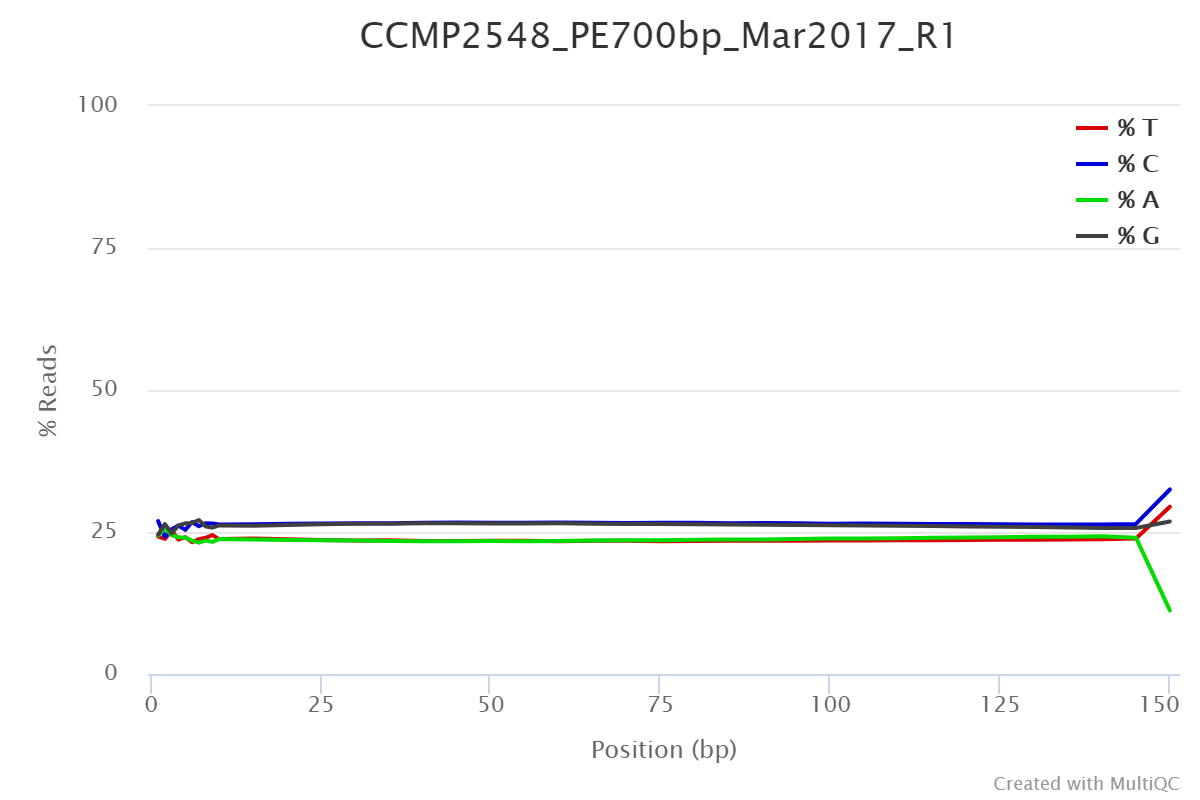

In [27]:
#Image(filename = PATH + "chart.png", width=500, height=500) #250bp library
#Image(filename = PATH + "chart (1).png", width=500, height=500) #700bp April
#Image(filename = PATH + "chart (2).png", width=500, height=500) #700bp December
Image(filename = PATH + "chart (3).png", width=500, height=500) #700bp March

**Above:** Nucleotide bias was apparent at either end of reads of all 700bp libraries

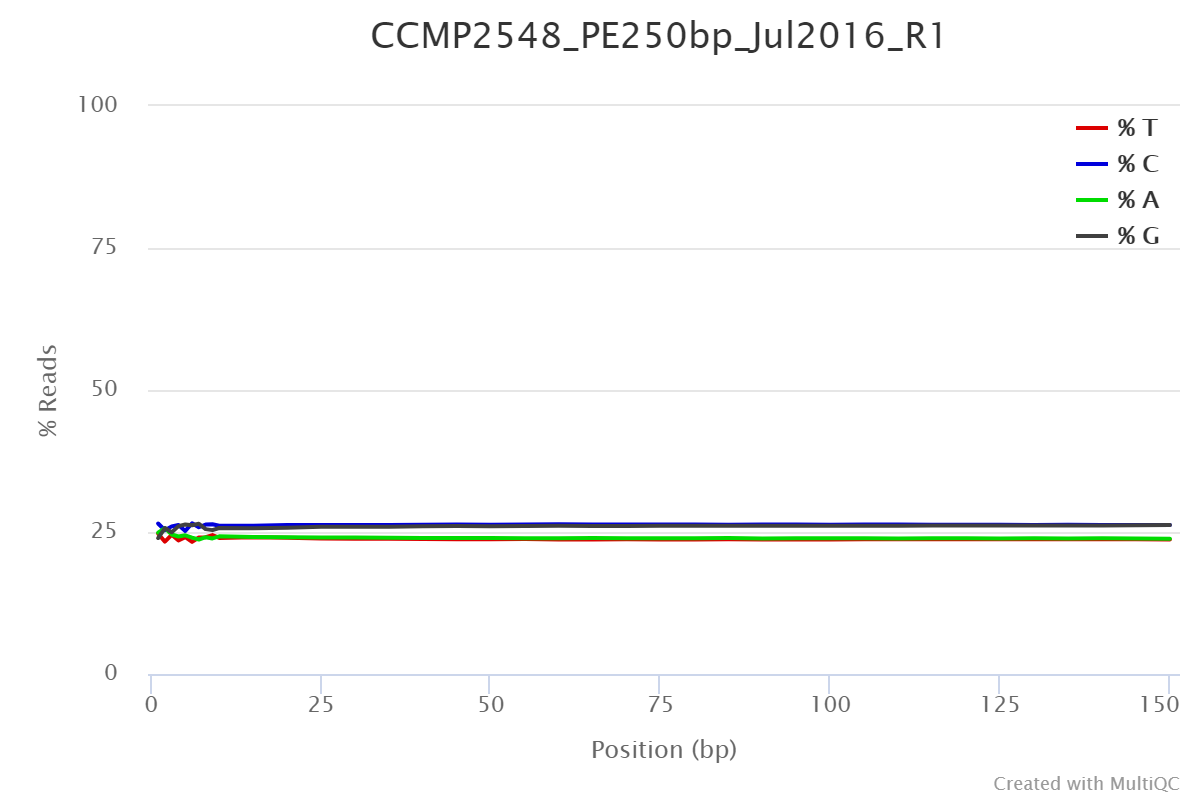

In [12]:
Image(filename = PATH + "chart.png", width=500, height=500) #250bp library

**Above:** The single 250bp library only showed significant bias in the first ~10 nucleotides of reads

750bp and 250bp libraries were trimmed with different parameters due to this nucleotide bias. Paramaters outlined below.

### Trimming of raw reads

Reads were trimmed stringently (>Q30). Libraries were trimmed the same except that the trailing 5 bases were removed from 700bp libraries and not from the 250bp library.

In [ ]:
#PBS -V -l nodes=1:ppn=16,mem=30GB,walltime=100:00:00
#PBS -k oe
#PBS -N Trimmomatic_Chris_PE

cd $PBS_O_WORKDIR #dir where you submitted job 

module load trimmomatic/0.36 #load trimmomatic

trim_250_jul() {
R1=$1
R1_prefix=$(echo $R1 | cut -d'/' -f5 | cut -d'.' -f1)
R2=$(echo $R1 | sed 's/R1/R2/g') 
R2_prefix=$(echo $R1 | cut -d'/' -f5 | cut -d'.' -f1 | sed 's/R1/R2/g')
trimlog_prefix=$(echo $R1 | cut -d'/' -f5  | cut -d'.' -f1 | cut -d'_' -f1-3)
adapter_file=$2
trimmomatic PE -threads 16 -phred33 -trimlog ${trimlog_prefix}_trimlog $R1 $R2 ${R1_prefix}_trimmed.fastq.gz ${R1_prefix}_Fsingle.fastq.gz ${R2_prefix}_trimmed.fastq.gz ${R2_prefix}_Rsingle.fastq.gz \
ILLUMINACLIP:${adapter_file}:2:30:10 HEADCROP:10 LEADING:30 TRAILING:30 SLIDINGWINDOW:4:25 MINLEN:100 AVGQUAL:30
}

trim_700_all() {
R1=$1
R1_prefix=$(echo $R1 | cut -d'/' -f5 | cut -d'.' -f1)
R2=$(echo $R1 | sed 's/R1/R2/g') 
R2_prefix=$(echo $R1 | cut -d'/' -f5 | cut -d'.' -f1 | sed 's/R1/R2/g')
trimlog_prefix=$(echo $R1 | cut -d'/' -f5  | cut -d'.' -f1 | cut -d'_' -f1-3)
adapter_file=$2
trimmomatic PE -threads 16 -phred33 -trimlog ${trimlog_prefix}_trimlog $R1 $R2 ${R1_prefix}_trimmed.fastq.gz ${R1_prefix}_Fsingle.fastq.gz ${R2_prefix}_trimmed.fastq.gz ${R2_prefix}_Rsingle.fastq.gz \
ILLUMINACLIP:${adapter_file}:2:30:10 CROP:145 HEADCROP:10 LEADING:30 TRAILING:30 SLIDINGWINDOW:4:25 MINLEN:100 AVGQUAL:30
}

#arg 1: path to the first read of a pair (fastq.gz format)
#arg 2: path to the adapter file
trim_250_jul /home/c.wrona/Reads/CCMP2548_PE250bp_Jul2016_R1.fastq.gz /home/c.wrona/TrimmomaticAdapters/TruSeq3-PE-AD12.fa
trim_700_all /home/c.wrona/Reads/CCMP2548_PE700bp_Apr2017_R1.fastq.gz /home/c.wrona/TrimmomaticAdapters/TruSeq3-PE-AD19.fa
trim_700_all /home/c.wrona/Reads/CCMP2548_PE700bp_Dec2016_R1.fastq.gz /home/c.wrona/TrimmomaticAdapters/TruSeq3-PE-AD19.fa 
trim_700_all /home/c.wrona/Reads/CCMP2548_PE700bp_Mar2017_R1.fastq.gz /home/c.wrona/TrimmomaticAdapters/TruSeq3-PE-AD19.fa 

In [26]:
trim_parameters = pd.read_csv(PATH + 'trimmomatic_parameters.csv', sep=',')
trim_parameters

,LIB_SIZE,LIB_DATE,ADAPTER_FILE,ILLUMINACLIP,HEADCROP,CROP,LEADING,TRAILING,SLIDINGWINDOW,MINLEN,AVGQUAL
0,250bp,Jul-16,TruSeq3-PE-AD12.fa,2:30:10,10,0,30,30,4:25,100,30
1,700bp,Apr-17,TruSeq3-PE-AD19.fa,2:30:10,10,5,30,30,4:25,100,30
2,700bp,Dec-16,TruSeq3-PE-AD19.fa,2:30:10,10,5,30,30,4:25,100,30
3,700bp,Mar-17,TruSeq3-PE-AD19.fa,2:30:10,10,5,30,30,4:25,100,30


**Above:** Trimmomatic parameters used for paired-end trimming of raw reads

In [33]:
trim_results = pd.read_csv(PATH + 'trimmomatic_results.csv', sep=',')
trim_results = trim_results.dropna(axis='columns')
trim_results

,LIB_SIZE,LIB_DATE,INPUT_READ_PAIRS,BOTH_SURVIVING,F_ONLY_SURVIVING,R_ONLY_SURVIVING,DROPPED
0,250bp,Jul-16,145309725,72.16%,11.12%,3.63%,13.09%
1,700bp,Apr-17,336124922,45.88%,23.14%,6.86%,24.12%
2,700bp,Dec-16,338993180,36.96%,36.87%,3.29%,22.88%
3,700bp,Mar-17,361275938,24.28%,24.32%,7.84%,43.56%


**Above:** Trimmomatic results. A lot of reads were dropped due to highly stringent cutoffs.

# K-mer counting with Jellyfish
Obtain an estimate of the coverage for each library and genome size. This was done to inform whether I will likely have enough coverage for variant calling (100X) with just paired end reads in which both survived trimming.

**Tools:** Jellyfish, R (script is written in R)

Guide for manually checking a single library and single k-mer size.  
http://koke.asrc.kanazawa-u.ac.jp/HOWTO/kmer-genomesize.html

In [ ]:
##Directory to all my .histo files
files <- list.files(path="C:\\Users\\chris\\OneDrive\\Symbiodinium\\jellyfish\\jellyfish_histograms\\", full.names=T, recursive=FALSE)

##Empty dataframe with appropriate column names
jellyfish_dataframe <- data.frame(Name=character(),
                                  Peak_Size=integer(), 
                                  Total_Genome_Size=integer(), 
                                  stringsAsFactors=FALSE) 


##Loop through each histogram file
for (file in files){
  data <- read.table(file) ##Read file into a table
  suffix <- unlist(strsplit((substring(file, 69)), split='.',fixed=TRUE))[1] ##Save a portion of file name
  
  ##Find the index after the initial skewed values
  for (count in 2:10){
    if (data[count,'V2'] < data[count-1,'V2'])
      start_index <- count 
  }
  
  ##Calculations
  subset <- data[start_index:nrow(data),] ##Subset the dataframe to exclude erroneous starting values
  peak_pos <- which.max(subset$V2) + (start_index-1)
  tot_genome_size <- sum(as.numeric(subset[,1]*subset[,2]))/peak_pos
  
  
  ##Append results to the empty dataframe initialised earlier
  temp_df <- data.frame(Name=suffix, Peak_Size=peak_pos, Total_Genome_Size=tot_genome_size)
  jellyfish_dataframe <- rbind(jellyfish_dataframe, temp_df)
}

##Write out the (not averaged) values to a txt file (commented out)
#write.table(jellyfish_dataframe, file = "jellyfish_output.txt", append = FALSE, quote = TRUE, sep = " ")


##Create vectors of averaged values for each library
avg_peaks <- round(colMeans(matrix(jellyfish_dataframe$Peak_Size, nrow=6)), digits=2)
avg_sizes <- colMeans(matrix(jellyfish_dataframe$Total_Genome_Size, nrow=6))
avg_names <- matrix(jellyfish_dataframe$Name[seq(1, nrow(jellyfish_dataframe) , 6)])

avg_peaks
avg_sizes
avg_names

##clean up avg_names vector (remove the '_xxmer' suffix)
strip_ends <- function(txt){
    return (substr(txt, 1, nchar(txt)-6))
}

avg_names <- apply(avg_names, 1, strip_ends) 

##Join vectors into a final dataframe of average values!
averaged_dataframe <- data.frame(Name=avg_names, 
                                 Avg_Peak_size=avg_peaks, 
                                 Avg_Genome_Size=avg_sizes)

In [4]:
jellyfish_results = pd.read_csv(PATH + 'jellyfish_averaged_results.csv', sep=',')
jellyfish_per_kmer_results = pd.read_csv(PATH + 'jellyfish_per_kmer_size.csv', sep=',')

jellyfish_results

,Name,Peak_Size,Genome_Size
0,CCMP2548_PE250bp_Jul2016,27.33,813913049.0
1,CCMP2548_PE700bp_Apr2017,38.17,772902259.0
2,CCMP2548_PE700bp_Dec2016,29.50,798388419.0
3,CCMP2548_PE700bp_Mar2017,17.33,821407497.0
4,CCMP2548_PE400bp_Apr2018_P1,10.00,685048005.0
5,CCMP2548N_PE400bp_Apr2018_P1,10.83,812544134.0
6,Total coverage/size estimates,133.16,784033893.8


In [42]:
jellyfish_results['Peak_Size'][0:5].sum() 
##Estimated coverage excluding CCMP2548N (as this was included seperately in the analysis)

122.33

**Above:** Estimated peak size (corresponding to coverage) and genome size averaged across kmer sizes 19, 21, 23, 25, 27, 29  
**Below:** (commented out) individual/raw results for each kmer size

In [5]:
jellyfish_per_kmer_results

,Name,Peak_Size,Estimated_Genome_Size
0,CCMP2548_PE250bp_Jul2016_19mer,29,795698197.7
1,CCMP2548_PE250bp_Jul2016_21mer,28,813540736.7
2,CCMP2548_PE250bp_Jul2016_23mer,28,801633368.9
3,CCMP2548_PE250bp_Jul2016_25mer,27,817977852.3
4,CCMP2548_PE250bp_Jul2016_27mer,26,834849748.2
5,CCMP2548_PE250bp_Jul2016_29mer,26,819778392.2
6,CCMP2548_PE400bp_Apr2018_P1_19mer,10,874610913.5
7,CCMP2548_PE400bp_Apr2018_P1_21mer,10,702281930.2
8,CCMP2548_PE400bp_Apr2018_P1_23mer,10,674059282.0
9,CCMP2548_PE400bp_Apr2018_P1_25mer,10,646574698.5


## Split .fastq.gz ##

Split 400bp library files prior to read mapping to allow samples run on lane 6 and lane 8 to be differentiated in readgroup information.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=8,mem=20GB,walltime=150:00:00
#PBS -k oe
#PBS -l wd
#PBS -N split_400bp_N

cd /home/564/cw7616/Chris/PE_400bp_trimmed/paired

zcat CCMP2548_PE400bp_Apr2018_P1.fastq.gz | grep --no-group-separator -A 3 "HNW23BBXX:8" > CCMP2548_L8_PE400bp_Apr2018_P1.fastq

gzip CCMP2548_L8_PE400bp_Apr2018_P1.fastq

zcat CCMP2548_PE400bp_Apr2018_P1.fastq.gz | grep --no-group-separator -A 3 "HNW23BBXX:6" > CCMP2548_L6_PE400bp_Apr2018_P1.fastq

gzip CCMP2548_L6_PE400bp_Apr2018_P1.fastq


Manually check that the lengths of split files (L6 and L8) add up to the original file to ensure all reads are accounted for.

In [ ]:
zcat CCMP2548_PE400bp_Apr2018_P1.fastq.gz | wc -l 
zcat CCMP2548_L6_PE400bp_Apr2018_P1.fastq.gz | wc -l
zcat CCMP2548_L8_PE400bp_Apr2018_P1.fastq.gz | wc -l

# Read Mapping

**tools:** bwa, samtools  
  
**input:** trimmed fastq.gz files for each pair  
**output:** bam files for each pair  
  
**bwa parameters**  
-M	Mark shorter split reads (chimeras) as secondary for Picard compatibility.  
-R  Complete read group header line.  

**samtools**  
output is piped to *samtools view -bS*  
-b  Output in the BAM format.  
-S  Ignored for compatibility with previous samtools versions.  

  
**bwa manual page**
http://bio-bwa.sourceforge.net/bwa.shtml

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=20GB,walltime=200:00:00
#PBS -k oe
#PBS -l wd
#PBS -N readgroup_fix_bwa

export INDIR=/home/564/cw7616/Chris/all_PE
cd $INDIR

module load samtools/1.4

bwa_all()
{
R1=$1 
R1_prefix=$(echo $R1 | cut -d'/' -f7)
R2=$(echo $R1 | sed 's/R1/R2/g')
R2_prefix=$(echo $R2 | cut -d'/' -f7)

OUTFILE=$(echo $R1_prefix | cut -d'_' -f1-3)

bwa mem -M -R "@RG\tID:${2}\tPL:"ILLUMINA"\tSM:${3}\tLB:${4}" /
    sspace_MPclean.final.scaffolds.fasta /
    ${R1_prefix} ${R2_prefix} | samtools view -bS - > ${OUTFILE}.bam
}



#$1 = path to read
#$2 = flowcell ID and number
#$3 = Sample (all are CCMP2548)
#$4 = Library information
#Note that these readgroups were lated adjusted using Picard's AddOrReplaceReadgroups
bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_PE250bp_Jul2016_R1_trimmed.fastq.gz "HM75TBCXX:2" "CCMP2548" "PE250JUL2016"

bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_PE700bp_Apr2017_R1_trimmed.fastq.gz "HHLL2BBXX:8" "CCMP2548" "PE700APR2017"

bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_PE700bp_Dec2016_R1_trimmed.fastq.gz "HGLFMBBXX:8" "CCMP2548" "PE700DEC2016"

bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_PE700bp_Mar2017_R1_trimmed.fastq.gz "HGVVMBBXX:8" "CCMP2548" "PE700MAR2017"

bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_L6_PE400bp_Apr2018_sorted.bam "HNW23BBXX:6" "CCMP2548" "PE400APR"

bwa_all /home/564/cw7616/Chris/all_PE/CCMP2548_L8_PE400bp_Apr2018_sorted.bam "HNW23BBXX:8" "CCMP2548" "PE400APR"

## Sort by Coordinate
**tools:** picard  
  
BAM files are sorted by coordinate. For a coordinate sorted SAM/BAM file, read alignments are sorted first by the reference sequence name (RNAME) field using the reference sequence dictionary tag labeled SQ. Alignments within these subgroups are secondarily sorted using the left-most mapping position of the read (POS). Subsequent to this sorting scheme, alignments are listed arbitrarily.  
  
**input:** unsorted bam files  
**output:** sorted bam files  
  
**reference**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.1.0/picard_sam_SortSam.php

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=20GB,walltime=200:00:00
#PBS -k oe
#PBS -l wd
#PBS -N picard_sort


export INDIR=/home/564/cw7616/Chris/bams_all
export PICARD=/home/564/cw7616/programs/picard.jar
cd $INDIR


pic_sort()
{
input_name=$(echo $1 | cut -d "/"  -f7 )
output_name=$(echo $input_name | cut -d '.' -f1)_sorted.bam


java -jar ${PICARD} SortSam INPUT=$input_name OUTPUT=$output_name SORT_ORDER=coordinate

}

for filename in ${INDIR}/*; do
        pic_sort $filename
done

## Fix Readgroup Information
**tools:** picard  
  
**input:** sorted bam  
**output:** sorted bam with adjusted readgroups  
  
**reference:**  
https://broadinstitute.github.io/picard/command-line-overview.html#AddOrReplaceReadGroups
  
I adjusted readgroup information to reflect that each 700bp run was from the same library.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=20GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N fix_readgroups

module load java/jdk1.8.0_60
module load samtools/1.4

INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
PICARD=/home/564/cw7616/programs/picard.jar
cd $INDIR


fix_readgroups()
{
input_file=$1
RG_ID=$2
RG_LB=$3
RG_PL=$4
RG_PU=$5
RG_SM=$6
RG_DT=$7
output_file=$(echo $input_file | sed 's/.bam/_RGFIX.bam/')

echo $input_file
echo "outfile is $output_file"

java -jar $PICARD AddOrReplaceReadGroups I=$input_file O=$output_file RGID=$RG_ID RGLB=$RG_LB RGPL=$RG_PL RGPU=$RG_PU RGSM=$RG_SM RGDT=$RG_DT

}

fix_readgroups CCMP2548_PE700bp_Apr2017_sorted.bam "HHLL2BBXX:8" "PE700DECMARAPR" "ILLUMINA" "HHLL2BBXX:8" "CCMP2548" "2017-04-01"

fix_readgroups CCMP2548_PE700bp_Dec2016_sorted.bam "HGLFMBBXX:8" "PE700DECMARAPR" "ILLUMINA" "HGLFMBBXX:8" "CCMP2548" "2016-12-01"

fix_readgroups CCMP2548_PE700bp_Mar2017_sorted.bam "HGVVMBBXX:8" "PE700DECMARAPR" "ILLUMINA" "HGVVMBBXX:8" "CCMP2548" "2017-03-01"

fix_readgroups CCMP2548_PE250bp_Jul2016_sorted.bam "HM75TBCXX:2" "PE250JUL" "ILLUMINA" "HM75TBCXX:2" "CCMP2548" "2016-07-01"

fix_readgroups CCMP2548_L6_PE400bp_Apr2018_sorted.bam "HNW23BBXX:6" "PE400APR" "ILLUMINA" "HNW23BBXX:6" "CCMP2548" "2018-04-01"

fix_readgroups CCMP2548_L8_PE400bp_Apr2018_sorted.bam "HNW23BBXX:8" "PE400APR" "ILLUMINA" "HNW23BBXX:8" "CCMP2548" "2018-04-01"

## Collect Alignment Metrics and Remove Duplicates
**tools:** samtools, picard, R
  
**input:** sorted bam  
**output metrics:** alignment metrics, insert metrics, insert size histogram, depth metrics    
**output remove duplicates:** bam file with duplicates removed, duplicate metrics  
 
**notes:**  
It was important to parse -Xmx80g to java when running Picard's MarkDuplicates to prevent it throwing an error regarding insufficient memory. Note that simply supplying more memory in the PBS header is not sufficient without the java arguement. I also had to point to a temp folder in my directory to store temp files, as the default directory had very limited capacity.  
  
**references:**  
CollectAlignmentSummaryMetrics: https://software.broadinstitute.org/gatk/documentation/tooldocs/current/picard_analysis_CollectAlignmentSummaryMetrics.php  
CollectInsertSizeMetrics:  
https://broadinstitute.github.io/picard/command-line-overview.html  
MarkDuplicates:  
https://broadinstitute.github.io/picard/command-line-overview.html#MarkDuplicates  

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=80GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 3_4_metrics_dedupe

export PICARD=/home/564/cw7616/programs/picard.jar
export INDIR=/home/564/cw7616/Chris/variant_calling/sorted_bams
cd $INDIR

module load samtools/1.4
module load java/jdk1.8.0_60
module load R/3.4.3

export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta

###COLLECT ALIGNMENT AND INSERT SIZE METRICS###
collect_metrics()
{
input_name=$(echo $1 | cut -d "/"  -f8 )
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/_sorted_RGFIX//')

java -jar $PICARD CollectAlignmentSummaryMetrics R=$2 I=$input_name O=alignment_metrics_${output_name}.txt

java -jar $PICARD CollectInsertSizeMetrics INPUT=${input_name} OUTPUT=insert_metrics_${output_name}.txt HISTOGRAM_FILE=ins_size_histo_${output_name}.pdf

samtools depth -a ${input_name} > depth_out_${output_name}.txt
}


###REMOVE DUPLICATES###
pic_dedup()
{
input_name=$(echo $1 | cut -d "/"  -f8 )
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/_sorted_RGFIX//')


java -Xmx80g -Djava.io.tmpdir=`pwd`/tmp  -jar ${PICARD} MarkDuplicates INPUT=${input_name} OUTPUT=${output_name}_dedup.bam METRICS_FILE=${output_name}_dedup_metrics.txt TMP_DIR=`pwd`/tmp
}

for filename in ${INDIR}/*RGFIX.bam; do
        collect_metrics $filename $REF
	pic_dedup $filename
done

## Merge bams
**tools:** picard
  
**input:** bam file with duplicates removed  
**output files:** single bam file with data from all libraries
   
I collected metrics on each final individually above as I thought maybe having that individual information would be useful. I then wanted to merge all my BAM's into a single file so variants could all be called together (and all further downstream processing).  
  
**references:**   
https://broadinstitute.github.io/picard/

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=40GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N merge_bams

export INDIR=/home/564/cw7616/Chris/variant_calling/4_5_dedup
export PICARD=/home/564/cw7616/programs/picard.jar
cd $INDIR

module load java/jdk1.8.0_60

F1=CCMP2548_L6_PE400bp_Apr2018_dedup.bam
F2=CCMP2548_L8_PE400bp_Apr2018_dedup.bam
F3=CCMP2548_PE250bp_Jul2016_dedup.bam
F4=CCMP2548_PE700bp_Apr2017_dedup.bam
F5=CCMP2548_PE700bp_Dec2016_dedup.bam
F6=CCMP2548_PE700bp_Mar2017_dedup.bam

java -jar $PICARD MergeSamFiles \
	I=$F1 \
	I=$F2 \
	I=$F3 \
	I=$F4 \
	I=$F5 \
	I=$F6 \
	O=CCMP2548_all_dedup.bam

## Index BAMs, Realignment Targets and Indel Realignment
**tools:** picard, gatk

### Index BAMs  
**input:** Merged bam file with duplicates removed.  
**output:** BAM index ".bai" file.  
  
**notes:**
This tool creates an index file for the input BAM that allows fast look-up of data in a BAM file, like an index on a database. Note that the input BAM file must be sorted in coordinate order.  
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.1.1/picard_sam_BuildBamIndex.php
  
  
### Realignment 1: Create Realignment Targets [NOT NEEDED]
**input:** Merged bam file with duplicates removed, reference genome  
**output:** realignment_targets.list file  
  
**notes:**
The local realignment process is designed to consume one or more BAM files and to locally realign reads such that the number of mismatching bases is minimized across all the reads. This process consists of 1) determining (small) suspicious intervals which are likely in need of realignment (RealignerTargetCreator) and 2) running the realigner over those intervals (IndelRealigner).    
  
**references:**   
https://software.broadinstitute.org/gatk/documentation/tooldocs/3.8-0/org_broadinstitute_gatk_tools_walkers_indels_RealignerTargetCreator.php
  
  
### Realignment 2: Indel Realignment [NOT NEEDED]
**input:** Merged bam file with duplicates removed, reference genome, list of realignment targets  
**output:** BAM file with realigned reads.    
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/3.8-0/org_broadinstitute_gatk_tools_walkers_indels_IndelRealigner.php
  
  
**additional notes:**  
Indel realignment is not actually deemed necessary in GATK version 4.xx best practices as it is now built into HaplotypeCaller, so this step was largely redundant.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=50GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 5_6_7_index_and_realign

export PICARD=/home/564/cw7616/programs/picard.jar
export INDIR=/home/564/cw7616/Chris/variant_calling/4_5_dedup
export GATK=/home/564/cw7616/programs/GenomeAnalysisTK.jar
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2
module load gatk/3.6

###Step 5###
bam_index()
{
input_name=$1

java -Xmx40g -Djava.io.tmpdir=`pwd`/tmp  -jar ${PICARD}  BuildBamIndex INPUT=${input_name} TMP_DIR=`pwd`/tmp
}



###Step 6###
gatk_realignment_targets()
{
input_name=$1
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/_dedup/_realignment_targets.list/')

java -Xmx40g -Djava.io.tmpdir=`pwd`/tmp -jar $GATK -T RealignerTargetCreator -R $REF -I $input_name -o ${output_name}
}

###Step 7###
gatk_realignment()
{
input_name=$1
target_name=$(echo $input_name | cut -d '.' -f1 | sed 's/_dedup/_realignment_targets.list/')
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/_dedup/_realigned_reads.bam/')

java -Xmx40g -Djava.io.tmpdir=`pwd`/tmp -jar $GATK -T IndelRealigner -R $REF -I $input_name -targetIntervals ${target_name} -o ${output_name}
}



bam_index CCMP2548_all_dedup.bam

gatk_realignment_targets CCMP2548_all_dedup.bam

gatk_realignment CCMP2548_all_dedup.bam


## First Round of Calling Variants
  
Reasoning: Base Quality Score Recalibration relies upon calculating 'empirical error' in base calls to find patterns in how covariates effect it. To do this, it makes the broad assumption that **any mismatch** against a reference is an error.  
In humans you would parse in a list of known variable sites to mask them from this, but since we have no known variant resource we bootstrap the variants in this way.
  
**tools:** GATK HaplotypeCaller  
  
**input:** Merged bam of realigned reads.  
**output:** "raw variant" vcf file.  
  
**notes:**  
Calls germline SNPs and indels via local re-assembly of haplotypes.
    - Identifies active regions (variation, coverage)
    - Assembles plausible haplotypes (graphs)
    - Likelihoods of each read against each possible haplotype (HMM)
    - Variant/genotype inference
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.4.0/org_broadinstitute_hellbender_tools_walkers_haplotypecaller_HaplotypeCaller.php
  
  

**additional notes:**  
Computationally itensive (walltime used: 42:29:11)

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=200:00:00
#PBS -l wd
#PBS -M christopher.wrona@uqconnect.edu.au
#PBS -m abe
#PBS -N 8_call_variants_GATK4

export INDIR=/home/564/cw7616/Chris/variant_calling/4_5_dedup
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2


call_variants()
{
input_name=$1
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/raw_variants.vcf/')

gatk HaplotypeCaller -R $REF -I $input_name -O $output_name
}


call_variants CCMP2548_all_realigned_reads.bam 

## Extract SNPs and Indels
**tools:** GATK SelectVariants  
  
**input:**   raw variant vcf file  
**output:**  raw SNP vcf file, raw INDEL vcf file  
  
**notes:**  
This step separates SNPs and INDELs into individual files so they can be processed independently.  
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/4.beta.6/org_broadinstitute_hellbender_tools_walkers_variantutils_SelectVariants.php


In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 9_extract_snps+indels

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

gatk_extract()
{
input_name=$1
snp_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_variants/raw_snps.vcf/')
indel_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_variants/raw_indels.vcf/')

echo $snp_out
echo $indel_out

gatk SelectVariants -R $REF -V $input_name --select-type SNP -O $snp_out

gatk SelectVariants -R $REF -V $input_name --select-type INDEL -O $indel_out

}

gatk_extract CCMP2548_all_raw_variants.vcf

## Filter SNPs and Indels
**tools:** GATK VariantFiltration
  
**input:**   raw SNP vcf file, raw INDEL vcf file
**output:**  filtered SNP vcf file, filtered INDEL vcf file  
  
**notes:**  
Apply filtering parameters to SNPs and INDELs based on criteria recommended in GATK best practices. These criteria are as follows:  
  
    SNP criteria  
    - QD < 2.0  
    - FS > 60.0   
    - MQ < 40.0  
    - MQRankSum < -12.5  
    - ReadPosRankSum < -8.0  
    - SOR > 4.0  
    INDEL criteria  
    - QD < 2.0  
    - FS > 200.0  
    - ReadPosRankSum < -20.0  
    - SOR > 10.0  
  
**references:**  
good articles explaining filtering criteria here:  
https://gatkforums.broadinstitute.org/gatk/discussion/2806/howto-apply-hard-filters-to-a-call-set  
https://gatkforums.broadinstitute.org/gatk/discussion/6925/understanding-and-adapting-the-generic-hard-filtering-recommendations  https://software.broadinstitute.org/gatk/documentation/article.php?id=3225
  
  
  
**adjusting filtering parameters:**  
https://software.broadinstitute.org/gatk/documentation/article.php?id=6925  
*recommended* parameters have been deduced from datasets with VQSR/truthsets.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 10_11_filter

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

gatk_filter()
{
input_name=$1
indel_name=$(echo $input_name | sed 's/snps/indels/')

snp_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_snps/filtered_snps.vcf/')
indel_out=$(echo $indel_name | cut -d '.' -f1 | sed 's/raw_indels/filtered_indels.vcf/')

gatk VariantFiltration -R $REF -V $input_name --filter-expression 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0 || SOR > 4.0' --filter-name "basic_snp_filter" -O $snp_out

gatk VariantFiltration -R $REF -V $indel_name --filter-expression 'QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0 || SOR > 10.0' --filter-name "basic_indel_filter" -O filtered_indels.vcf


}


gatk_filter CCMP2548_all_raw_snps.vcf

## Base Quality Score Recalibration (BQSR) 1
**tools:** GATK BaseRecalibrator  
  
**input:**   realigned reads bam file, filtered snp and variant vcf files, reference genome  
**output:**  data table with recalibrated base scores  
  
**notes:**  
Data pre-processing step that detects systematic errors made by the sequencing machine when it estimates the accuracy of each base call. Systematic errors are linked to:
    - Readgroup of the sample
    - Reported quality score
    - Position in the read (and if its first or second of pair, second is generally lower quality)
    - Nucleotide context
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/3.8-0/org_broadinstitute_gatk_tools_walkers_bqsr_BaseRecalibrator.php  
  
https://gatkforums.broadinstitute.org/gatk/discussion/44/base-quality-score-recalibration-bqsr

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 12_BQSR

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

BQSR()
{
input_name=$1
snps=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/filtered_snps.vcf/')
indels=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/filtered_indels.vcf/')
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/recal_data.table/')

gatk BaseRecalibrator -R $REF -I $input_name --known-sites $snps --known-sites $indels -O $output_name

}


BQSR CCMP2548_all_realigned_reads.bam

Note that this point earlier versions of GATK allow for an immediate second round of base quality score recalibration. This is not possible in GATK4, instead the recalibration table from the first pass of BQSR is applied to the realigned reads bam producing a recalibrated bam. BQSR is then repeated on the recalibrated bam to produce a 'post recalibrated bam'.

## Apply BQSR
**tools:** GATK ApplyBQSR
  
**input:**   realigned reads bam file, recalibrated data table, reference genome  
**output:**  recalibrated reads bam file  
  
**notes:**  
Apply the recalibration to the original bam file. ApplyBQSR has now superceded PrintReads which was suggested in the gencore pipeline (link in the first cell).  
  
**references:**  
https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.0.0/org_broadinstitute_hellbender_tools_walkers_bqsr_ApplyBQSR.php

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 15_apply_bqsr

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

apply_BQSR()
{
input_name=$1
recal_table=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/recal_data.table/')
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/realigned_reads/recal_reads.bam/')


gatk ApplyBQSR -R $REF -I $input_name -bqsr $recal_table -O $output_name

}


###Note that ApplyBQSR has superceded PrintReads recommended in the pipeline

apply_BQSR CCMP2548_all_realigned_reads.bam

## Base Quality Score Recalibration  - 2
**tools:** GATK BaseRecalibrator 
  
**input:**   recalibrated reads bam file, filtered snp and variant vcf files, reference genome  
**output:**  post recalibration data table 
  
**notes:**  
Data pre-processing step that detects systematic errors made by the sequencing machine when it estimates the accuracy of each base call.  
  
**references:**  
GATK3 documentation (most recent that I can find) https://software.broadinstitute.org/gatk/documentation/tooldocs/3.8-0/org_broadinstitute_gatk_tools_walkers_bqsr_BaseRecalibrator.php

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=24:00:00
#PBS -l wd
#PBS -q express
#PBS -N 13_BQSR_post

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

BQSR_post()
{
input_name=$1
snps=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/filtered_snps.vcf/')
indels=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/filtered_indels.vcf/')
recal_table=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/recal_data.table/')
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/post_recal_data.table/')


gatk BaseRecalibrator -R $REF -I $input_name --known-sites $snps --known-sites $indels  -O $output_name

}

###Note this actually requires step 15 to be completed first to generate a recalbirated BAM to use as input
###This is a change in GATK4 from GATK3, hence the slightly shuffled order necessary.

BQSR_post CCMP2548_all_recal_reads.bam

## Analyze Covariates [run locally]
**tools:** GATK, R
  
**input:**
reference genome, recalibration table, post_recalibration table  
**output:**  
plots of each covariate (pdf), plot data (csv)  
  
**notes:**  
Generate plots to assess the quality of a recalibration run as part of the BQSR procedure.
  
R packages required:
    - library("ggplot2")  
    - library(gplots)  
    - library("reshape")  
    - library("grid")  
    - library("tools")  
    - library(gsalib)  

In [ ]:
#!/bin/bash
INDIR=/home/chris/analyze_covariates
cd $INDIR

Analyze_Cov()
{
recal=$1
post_recal=$(echo $recal | cut -d '.' -f1 | sed 's/recal_data/post_recal_data.table/')
plot_out=$(echo $recal | cut -d '.' -f1 | sed 's/recal_data/recalibration_plots.pdf/')

gatk AnalyzeCovariates -before $recal -after $post_recal -csv cov_plot.csv -plots $plot_out
}

Analyze_Cov CCMP2548_all_recal_data.table

## Call Variants - Round 2
**tools:** gatk

Call variants taking into account recalibrated base quality scores. This is run the same way as the initial variant calling step (with Haplotype caller), only instead uses the newly recalibrated bam that takes into consideration the BQSR.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=200:00:00
#PBS -l wd
#PBS -M christopher.wrona@uqconnect.edu.au
#PBS -m abe
#PBS -N 16_call_variants_round_2

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

call_variants()
{
input_name=$1
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/raw_variants_recal.vcf/')

gatk HaplotypeCaller -R $REF -I $input_name -O $output_name
}

###Round 2 of calling reads, this time on the recalibrated BAM###
call_variants CCMP2548_all_recal_reads.bam 

## Extract and filter SNPs and Indels - Round 2
### The same criteria as earlier are applied

**tools:** GATK VariantFiltration
  
**input:**   raw SNP vcf file, raw INDEL vcf file
**output:**  filtered SNP vcf file, filtered INDEL vcf file  
  
**notes:**  
Apply filtering parameters to SNPs and INDELs based on criteria recommended in GATK best practices. These criteria are as follows:  
  
    SNP criteria  
    - QD < 2.0  
    - FS > 60.0   
    - MQ < 40.0  
    - MQRankSum < -12.5  
    - ReadPosRankSum < -8.0  
    - SOR > 4.0  
    INDEL criteria  
    - QD < 2.0  
    - FS > 200.0  
    - ReadPosRankSum < -20.0  
    - SOR > 10.0  
  
**references:**  
good article explaining filtering criteria here: https://gatkforums.broadinstitute.org/gatk/discussion/2806/howto-apply-hard-filters-to-a-call-set

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=100:00:00
#PBS -l wd
#PBS -M christopher.wrona@uqconnect.edu.au
#PBS -m abe
#PBS -N 17_18_19_Extract&Filter

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load python3/3.6.2

gatk_extract_2()
{
input_name=$1
snp_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_variants_recal/raw_snps_recal.vcf/')
indel_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_variants_recal/raw_indels_recal.vcf/')

echo $snp_out
echo $indel_out

gatk SelectVariants -R $REF -V $input_name --select-type SNP -O $snp_out

gatk SelectVariants -R $REF -V $input_name --select-type INDEL -O $indel_out
}

gatk_filter_2()
{
input_name=$1
indel_name=$(echo $input_name | sed 's/snps/indels/')

snp_out=$(echo $input_name | cut -d '.' -f1 | sed 's/raw_snps_recal/filtered_snps_recal_final.vcf/')
indel_out=$(echo $indel_name | cut -d '.' -f1 | sed 's/raw_indels_recal/filtered_indels_recal_final.vcf/')

gatk VariantFiltration -R $REF -V $input_name --filter-expression 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0 || SOR > 4.0' --filter-name "basic_snp_filter" -O $snp_out

gatk VariantFiltration -R $REF -V $indel_name --filter-expression 'QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0 || SOR > 10.0' --filter-name "basic_indel_filter" -O $indel_out
}


gatk_extract_2 CCMP2548_all_raw_variants_recal.vcf
gatk_filter_2 CCMP2548_all_raw_snps_recal.vcf

## SnpEff Annotation  [Requires .gff file]
**tools:** SnpEff

SnpEff is utilized to annotate and predict the effects of the variants. SnpEff annotates the input variants and calculates the effects they produce on known genes (e.g. amino acid changes). Requires a suitable reference/database to use, so this may not be possible (or useful for my needs).

*If your organism is not available in SnpEff, it is possible to create a custom SnpEff Database if a reference fasta and gff file are available.*

**reference:**  
http://snpeff.sourceforge.net/SnpEff.html

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=20GB,walltime=12:00:00
#PBS -l wd
#PBS -q express
#PBS -M christopher.wrona@uqconnect.edu.au
#PBS -m abe
#PBS -N 20_snpeff_annotate

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export SNPEFF=/home/564/cw7616/snpEff/snpEff.jar

cd $INDIR

module load java/jdk1.8.0_60

snp_annotate()
{
input_name=$1
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/filtered_snps__recal_final/filtered_snps_recal_final.ann.vcf/')

java -jar $SNPEFF -v ?database? $input_name > $output_name

}

snp_annotate CCMP2548_all_filtered_snps_recal_final.vcf  

## Compute Coverage Statistics
**tools:** bedtools

**parameters:**  
-bga: by using the -bga option, one receives a complete report including the regions with zero coverage.

*"load the genomecov.bedgraph output file into IGV to view a coverage map at the entire genome or chromosome level"*  
Issue with this - bedgraph file is too large. Tried to convert it to TDF format as reccommended by IGV but have issues with providing a genome file see link here: https://software.broadinstitute.org/software/igv/igvtools_commandline
  
**references:**  
http://bedtools.readthedocs.io/en/latest/content/tools/genomecov.html

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=20GB,walltime=20:00:00
#PBS -l wd
#PBS -q express
#PBS -N 21_coverage_stats

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
export REF=/home/564/cw7616/Chris/variant_calling/reference_genome/sspace_MPclean.final.scaffolds.fasta
cd $INDIR

module load java/jdk1.8.0_60
module load bedtools/2.26.0


calc_coverage()
{
input_name=$1
output_name=$(echo $input_name | cut -d '.' -f1 | sed 's/recal_reads/genome_cov.bedgraph/')

bedtools genomecov -bga -ibam $input_name > genomecov.bedgraph

}

calc_coverage CCMP2548_all_recal_reads.bam 

## Compile and Summarise Statistics
**tools:** N/A  
  
Simple script for parsing metric and vcf files provided as part of the general pipeline I was following, can be found at the following link:  
https://github.com/gencorefacility/variant-calling-pipeline/blob/master/parse_metrics.sh  
  
For results see the other notebook.

In [ ]:
#PBS -P d85
#PBS -V -l ncpus=16,mem=32GB,walltime=1:00:00
#PBS -l wd
#PBS -q express
#PBS -N final_report_csv

export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir/metrics
cd $INDIR

ID=CCMP2548_all

input=alignment_metrics_${ID}.txt
while read line
do
	if [[ $line == PAIR* ]];then
		ALIGNMENT_METRICS=$(echo $line | cut -d' ' -f2,6,7,10,16,18 | tr ' ' ',') 
	fi
done < $input

re='^[0-9]+([.][0-9]+)?$'

input=insert_metrics_${ID}.txt
while read line
do
	MEAN_INSERT_SIZE=$(echo $line | cut -d' ' -f5)
	if [[ $MEAN_INSERT_SIZE =~ $re ]];then
        	break
	fi
done < $input

#grep note:
#^ means "start of line"
# is the literal character 
#-v means "invert the match" in grep i.e. return all non matching lines.

snps_1=$(grep -v '^#' ${ID}_raw_snps.vcf | wc -l)
snps_2=$(grep 'PASS' ${ID}_filtered_snps.vcf | wc -l)
snps_3=$(grep -v '^#' ${ID}_raw_snps_recal.vcf | wc -l)
snps_4=$(grep 'PASS' ${ID}_filtered_snps_recal_final.vcf | wc -l)
avg_coverage=$(awk '{sum+=$3} END { print sum/NR}' depth_out_${ID}.txt)

echo "$ID,$ALIGNMENT_METRICS,$MEAN_INSERT_SIZE,$snps_1,$snps_2,$snps_3,$snps_4,$avg_coverage" >> ../full_report.csv

Below: Calculate the same summary statistics for indels. Very simple parsing of the vcf files, so it was run locally.

In [ ]:
#!/bin/bash
export INDIR=/home/564/cw7616/Chris/variant_calling/variant_working_dir
cd $INDIR

ID=CCMP2548_all

indels_1=$(grep -v '^#' ${ID}_raw_indels.vcf | wc -l)
indels_2=$(grep 'PASS' ${ID}_filtered_indels.vcf | wc -l)
indels_3=$(grep -v '^#' ${ID}_raw_indels_recal.vcf | wc -l)
indels_4=$(grep 'PASS' ${ID}_filtered_indels_recal_final.vcf | wc -l)


echo "$ID,$indels_1,$indels_2,$indels_3,$indels_4" >> ./metrics/indel_report.csv